In [4]:
#Importing the necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
import itertools
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss, r2_score
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler


import warnings
warnings.simplefilter('ignore')

In [5]:
breast_cancer_data= pd.read_csv("data.csv")

In [6]:
drop_list= ['Unnamed: 32','id']
breast_cancer_data.drop(drop_list, axis=1, inplace= True)

In [7]:
x_drop= ['diagnosis']
x= breast_cancer_data.drop(x_drop,axis=1)
x_std= (x-x.mean())/(x.std())
y= breast_cancer_data.diagnosis

## Feature Selection

### 1. Feature Selection with Correlation

### Dropping highly correlated columns

In [8]:
drop_list_correlation=['diagnosis','radius_mean','radius_se','radius_worst',
                      'perimeter_mean','perimeter_se','perimeter_worst',
                      'compactness_mean','compactness_se','compactness_worst',
                      'concave points_mean','concave points_se','concave points_worst',
                      'texture_worst', 'area_worst']

breast_cancer_data_new= breast_cancer_data.drop(drop_list_correlation,axis=1)

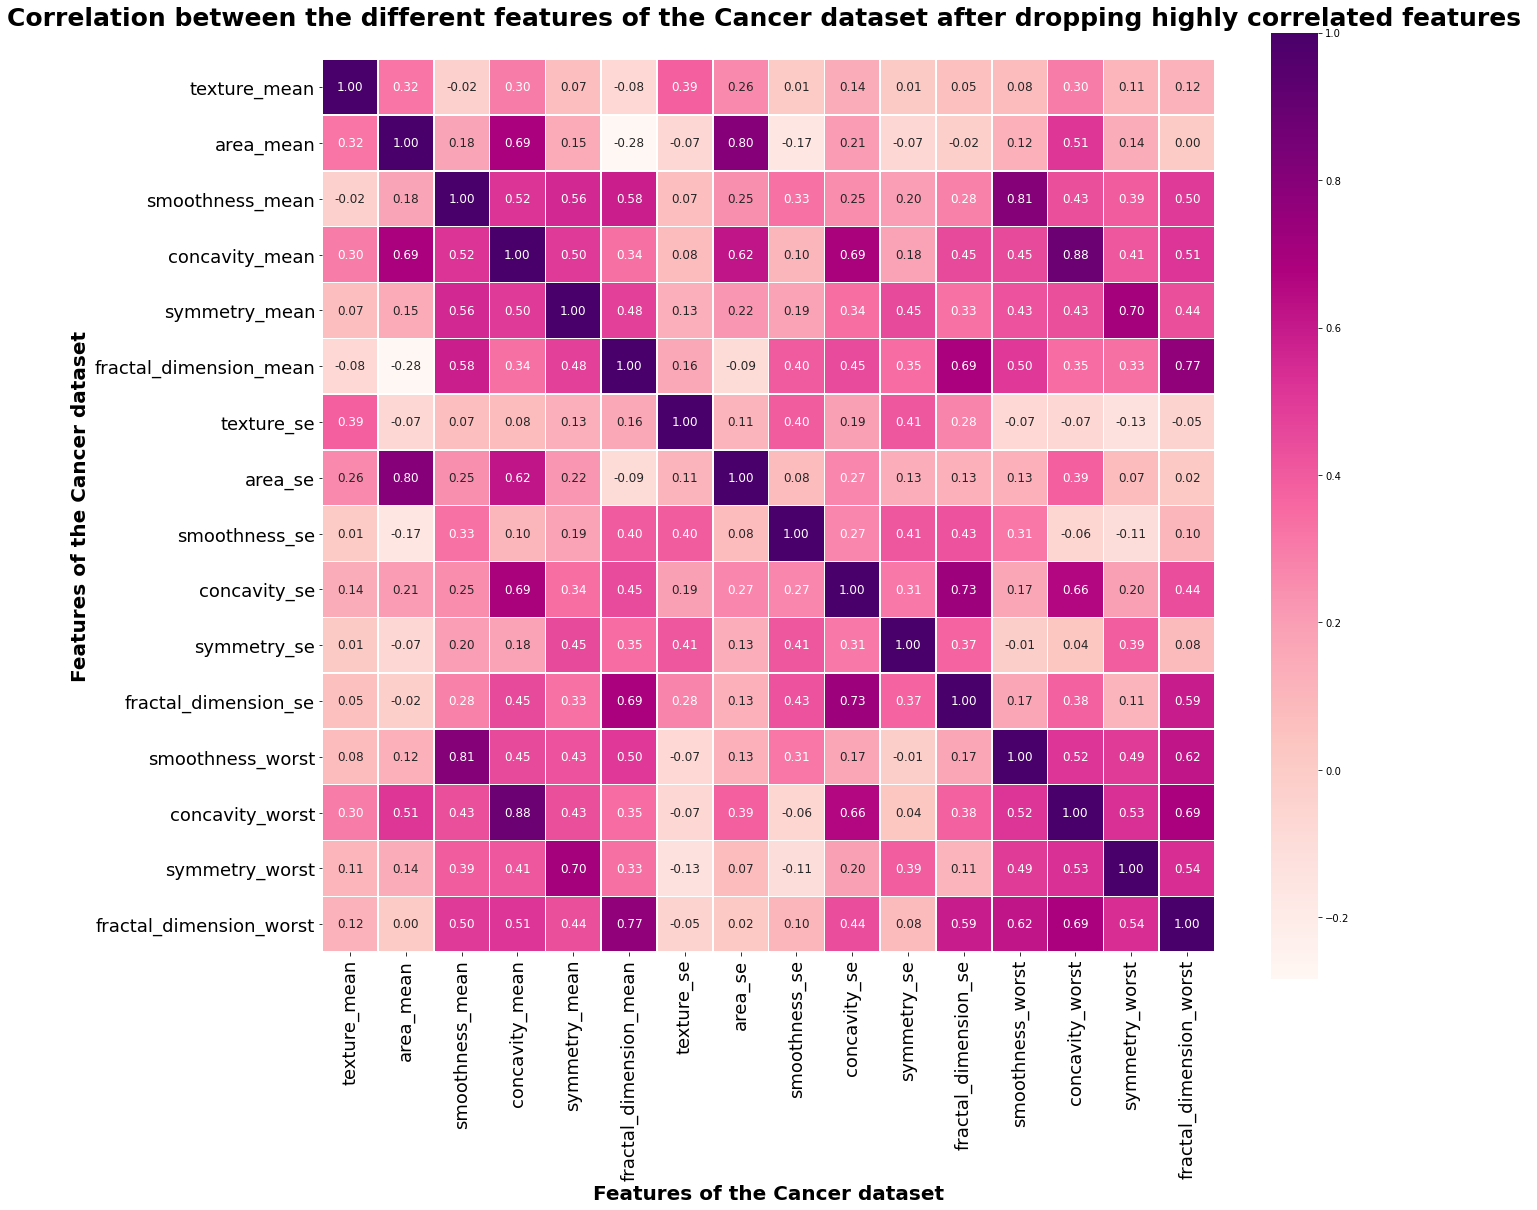

In [9]:
f,ax = plt.subplots(figsize=(20, 30))
cancer_correlated_features=breast_cancer_data_new.corr()
sns.heatmap(cancer_correlated_features, cmap='RdPu',annot=True,annot_kws={"size":12},square=True, linewidths=.5, fmt= '.2f',cbar_kws={'shrink': 0.58},ax=ax)
ax.set_title('Correlation between the different features of the Cancer dataset after dropping highly correlated features \n',fontsize=25,fontweight='bold')

ax.set_ylabel('Features of the Cancer dataset',fontsize=20,fontweight='bold')
ax.set_xlabel('Features of the Cancer dataset',fontsize=20,fontweight='bold')


ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
plt.show()

In [10]:
selected_features= breast_cancer_data_new.columns
selected_features

Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'area_se',
       'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')

In [11]:
fs_correlation= np.ones(len(breast_cancer_data_new.columns))
fs_correlation= pd.DataFrame(fs_correlation, columns = ["Correlation"], index=breast_cancer_data_new.columns)
fs_correlation = fs_correlation.astype({"Correlation": int}).reset_index()

The number of features were reduced from 30 to 16. To check if we've selected the right features using Feature Selection with Correlation, we will use the Random Forest classifier to compute accuracy of the selected features.

In [12]:
#writing y in binary form to compute recall score
y= y.replace("B", 0)
y= y.replace("M", 1)
x_train, x_test, y_train, y_test= train_test_split(breast_cancer_data_new,y,test_size=0.3,random_state=42 )

Recall is: 0.9365079365079365
Accuracy is: 0.9649122807017544
F1 score is: 0.9516129032258064


<AxesSubplot:>

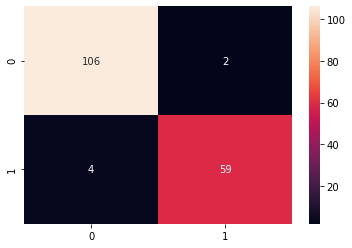

In [13]:
clf_rf= RandomForestClassifier(random_state=43)
clf_rf= clf_rf.fit(x_train, y_train)

recall= recall_score(y_test, clf_rf.predict(x_test))
print("Recall is:", recall)

accuracy= accuracy_score(y_test, clf_rf.predict(x_test))
print("Accuracy is:", accuracy)

f1= f1_score(y_test, clf_rf.predict(x_test))
print("F1 score is:", f1)

cm= confusion_matrix(y_test, clf_rf.predict(x_test))
sns.heatmap(cm, annot= True, fmt='d')

Recall is 93.7%. Accuracy and F1 scores look good. Feature selection using correlation gives us a few wrong predictions as can be seen from the confusion matirx. We shall proceed with other feature selection techniques and analyze their outcomes.

In [14]:
print("The selected features from Feature Selection using Correlation\n", fs_correlation['index'].values)

The selected features from Feature Selection using Correlation
 ['texture_mean' 'area_mean' 'smoothness_mean' 'concavity_mean'
 'symmetry_mean' 'fractal_dimension_mean' 'texture_se' 'area_se'
 'smoothness_se' 'concavity_se' 'symmetry_se' 'fractal_dimension_se'
 'smoothness_worst' 'concavity_worst' 'symmetry_worst'
 'fractal_dimension_worst']


### 2. Univariate Feature Selection (Chi-Square)

By using Univariate feature selection, we will be selecting the best features on the basis of univariate statistical tests where each feature will be compared to the target variable to identify if they're closely related. This is also referred to as Analysis of Variance (ANOVA).

We will be using SelectKBest method that selects only the k highest scoring features.

For this method, we need to choose the number of features i.e. k that we wish to work with. 

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)
selected_features_chi= SelectKBest( chi2, k=10).fit(x_train,y_train)
np.set_printoptions(suppress=True) 
scores=np.round(selected_features_chi.scores_,3)

In [16]:
fs_chi_sq= pd.DataFrame(scores, columns = ["Chi_Square"], index=x_train.columns)
fs_chi_sq= fs_chi_sq.reset_index()
fs_chi_sq= fs_chi_sq.sort_values('Chi_Square',ascending= False)

Recall is: 0.9473684210526315
Accuracy is: 0.9532163742690059
F1 score is: 0.9310344827586206


<AxesSubplot:>

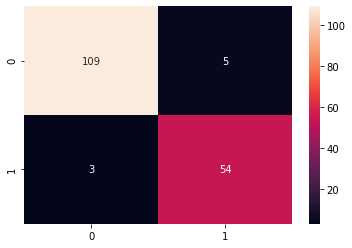

In [17]:
x_train_= selected_features_chi.transform(x_train)
x_test_= selected_features_chi.transform(x_test)
clf_rf2= RandomForestClassifier(n_estimators=16)
clf_rf2= clf_rf2.fit(x_train_,y_train)

recall_= recall_score(y_test, clf_rf2.predict(x_test_))
print("Recall is:", recall_)

accuracy_= accuracy_score(y_test, clf_rf2.predict(x_test_))
print("Accuracy is:", accuracy_)

f1_= f1_score(y_test, clf_rf2.predict(x_test_))
print("F1 score is:", f1_)

cm_= confusion_matrix(y_test, clf_rf2.predict(x_test_))
sns.heatmap(cm_, annot= True, fmt='d')

Recall is 94.7%  while Accuracy and F1 scores are slightly lower compared to Feature Selection using Correlation.

In [18]:
print("The selected features from Univariate Feature Selection\n", selected_features_chi.get_feature_names_out())

The selected features from Univariate Feature Selection
 ['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean' 'perimeter_se'
 'area_se' 'radius_worst' 'texture_worst' 'perimeter_worst' 'area_worst']


### 3. Recursive Feature Elimination (RFE) with Random Forest

Using Recursive Feature Elimination, we can choose those columns that have the most impact on the prediction of the target variable.

Recursive Feature Elimination works by fitting the chosen machine learning model with all features initially. It then recursively removes features, trains the model with this reduced feature set, calculates the model performance and notes what features are important.

This process is repeated until the required number of features are selected.

In [19]:
from sklearn.feature_selection import RFE

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

clf_rf_3 = RandomForestClassifier(random_state=43)      
rfe= RFE(estimator= clf_rf_3, n_features_to_select=16, step=1)
rfe= rfe.fit(x_train, y_train)

In [20]:
fs_rfe= pd.DataFrame(rfe.support_, columns=['RFE'], index= x_train.columns)
fs_rfe = fs_rfe.reset_index()

The chosen 16 features by Recursive Feature Elimination are different from the naive approach, hence we will compute the accruacy and recall again.

Recall is: 0.9649122807017544
Accuracy is: 0.9766081871345029
F1 score is: 0.9649122807017544


<AxesSubplot:>

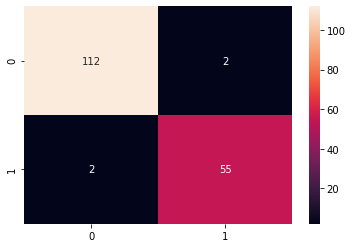

In [22]:
recall= recall_score(y_test, rfe.predict(x_test))
print("Recall is:", recall)

accuracy= accuracy_score(y_test, rfe.predict(x_test))
print("Accuracy is:", accuracy)

f1= f1_score(y_test, rfe.predict(x_test))
print("F1 score is:", f1)

cm= confusion_matrix(y_test, rfe.predict(x_test))
sns.heatmap(cm, annot= True, fmt='d')

Recall is 96.5% which is slighlty better than the previous naive approach for the same classifier with the same Random_State and the same test set. Let's now find the optimal number of features.

In [23]:
print('Total features: {}'.format((x_train.shape[1])))
print('Selected features: {}'.format(len(x_train.columns[rfe.support_])))
print('Chosen best 16 features by rfe: \n',x_train.columns[rfe.support_])

Total features: 30
Selected features: 16
Chosen best 16 features by rfe: 
 Index(['texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst'],
      dtype='object')


### 4. Recursive Feature Elimination with Cross-Validation (RFECV) with Random Forest

The feature_importances_ attribute of RandomForestClassifier can be used to calculate the importance of the features in the iteration. In RFECV, feature importance is computed based on the estimator selected, and a few features will be dropped in each iteration.


“n_features_” tells us the number of features that are important and make a significant impact in predicting the dependent variable.
“ranking_” feature indicates the order of importance for each feature.

In [24]:
from sklearn.feature_selection import RFECV

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

clf_rf_4= RandomForestClassifier(random_state=43) 
rfecv= RFECV(estimator=clf_rf_4, step=1, cv=5, scoring='accuracy') #5-fold cross validation
rfecv.fit(x_train, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(random_state=43),
      scoring='accuracy')

In [25]:
fs_rfecv= pd.DataFrame(rfecv.support_, columns = ["RFECV"], index=x_train.columns)
fs_rfecv = fs_rfecv.reset_index()

print('Total number of features: {}'.format((x_train.shape[1])))
#print('Number of selected features: {}'.format(len(x_train.columns[rfecv.support_])))
print('Optimal number of features:', rfecv.n_features_)
print('Best features by rfecv:', x_train.columns[rfecv.support_])

Total number of features: 30
Optimal number of features: 21
Best features by rfecv: Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'radius_se', 'perimeter_se', 'area_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


Recall is: 0.9473684210526315
Accuracy is: 0.9707602339181286
F1 score is: 0.9557522123893805


<AxesSubplot:>

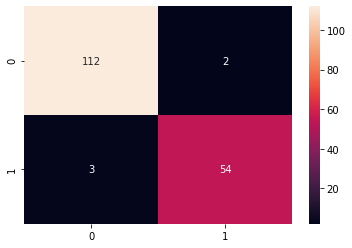

In [26]:
recall= recall_score(y_test, rfecv.predict(x_test))
print("Recall is:", recall)

accuracy= accuracy_score(y_test, rfecv.predict(x_test))
print("Accuracy is:", accuracy)

f1= f1_score(y_test, rfecv.predict(x_test))
print("F1 score is:", f1)

cm= confusion_matrix(y_test, rfecv.predict(x_test))
sns.heatmap(cm, annot= True, fmt='d')

In [25]:
#rfecv.grid_scores_

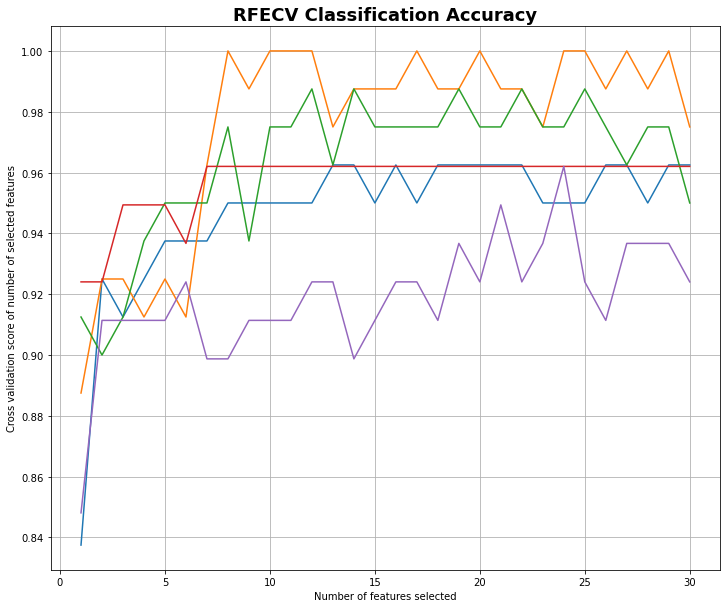

In [29]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("RFECV Classification Accuracy", fontsize=18, fontweight='bold')

plt.grid()
plt.show()

From this plot, we can see that keeping 8, 10, 11, 12, 16, 18, 20, 24, 25 or sometimes 27 features approximately gives the same accuracy.

In [28]:
opt_features = []
for rs in range(10):
    clf_rf_4 = RandomForestClassifier(random_state = rs) 
    rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5, scoring='accuracy')   #5-fold cross-validation
    rfecv = rfecv.fit(x_train, y_train)
    opt_features.append(rfecv.n_features_)
print("Number of optimal features :", opt_features)

Number of optimal features : [16, 25, 17, 15, 27, 17, 18, 17, 18, 24]


The number of optimal features fluctuates a lot for a same classifier. Hence, it is quite erroneous to base our understanding of the optimal feature selection on a single occurence of the cross validation.

### 5. Tree based feature selection (ExtraTrees)

With ExtraTreesClassifier it is possible to fit a number of randomized decision trees to the data, which is a form of ensemble learning. Random splits of the observations ensure that the model does not overfit the data.

Feature ranking:
1. Feature 6 (0.104908)
2. Feature 26 (0.091337)
3. Feature 23 (0.086060)
4. Feature 22 (0.083466)
5. Feature 7 (0.079033)
6. Feature 20 (0.072962)
7. Feature 27 (0.070245)
8. Feature 2 (0.052398)
9. Feature 3 (0.050545)
10. Feature 0 (0.041505)
11. Feature 1 (0.028941)
12. Feature 21 (0.025044)
13. Feature 24 (0.023806)
14. Feature 16 (0.021669)
15. Feature 25 (0.021036)
16. Feature 12 (0.019196)
17. Feature 28 (0.018840)
18. Feature 13 (0.016546)
19. Feature 29 (0.012679)
20. Feature 10 (0.012280)
21. Feature 17 (0.010384)
22. Feature 14 (0.007682)
23. Feature 5 (0.007203)
24. Feature 19 (0.007029)
25. Feature 11 (0.006910)
26. Feature 15 (0.006661)
27. Feature 9 (0.006552)
28. Feature 8 (0.005210)
29. Feature 4 (0.005028)
30. Feature 18 (0.004846)


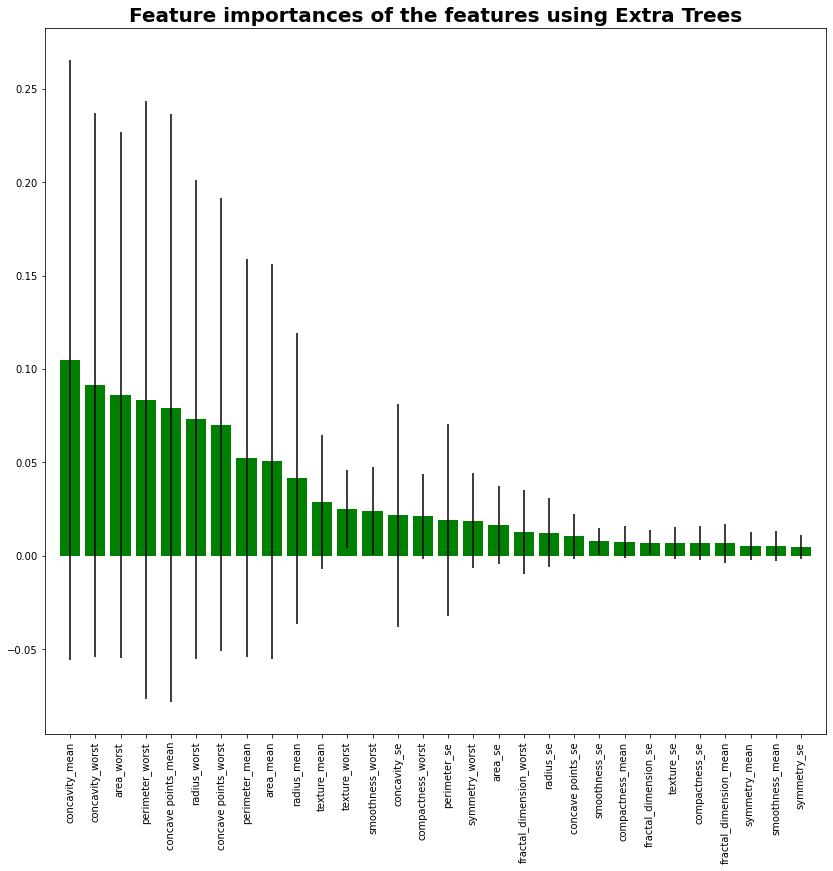

In [36]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

# Building a forest and computing impurity-based feature importances

clf_5= ExtraTreesClassifier(n_estimators=32,random_state=0)
clf_5.fit(x_train, y_train)
clf_5.feature_importances_ 
importances = clf_5.feature_importances_

model_reduced = SelectFromModel(clf_5, prefit=True)


std= np.std([tree.feature_importances_ for tree in clf_5.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances of the features using Extra Trees",fontweight='bold',fontsize='20')
plt.bar(range(x_train.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()        



In [38]:
# printing the number of total and selected features

selected_feature_extraTrees= x_train.columns[model_reduced.get_support()]

print('Total features: {}'.format((x_train.shape[1])))
print('Selected features: {}'.format(len(selected_feature_extraTrees)))
print('Best features by ExtraTrees:',x_train.columns[model_reduced.get_support()])

Total features: 30
Selected features: 10
Best features by ExtraTrees: Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')


In [98]:
fs_extratrees= pd.DataFrame(clf_5.feature_importances_, columns = ["Extratrees"], index=x_train.columns)
fs_extratrees = fs_extratrees.reset_index()

Recall is: 0.9473684210526315
Accuracy is: 0.9590643274853801
F1 score is: 0.9391304347826087


<AxesSubplot:>

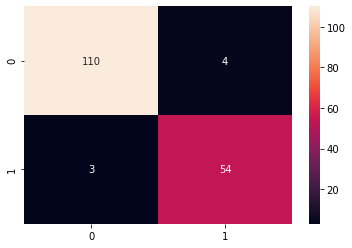

In [99]:
recall= recall_score(y_test, clf_5.predict(x_test))
print("Recall is:", recall)

accuracy= accuracy_score(y_test, clf_5.predict(x_test))
print("Accuracy is:", accuracy)

f1= f1_score(y_test, clf_5.predict(x_test))
print("F1 score is:", f1)

cm= confusion_matrix(y_test, clf_5.predict(x_test))
sns.heatmap(cm, annot= True, fmt='d')

### 6. Vote based Feature Selection

In [81]:
from functools import reduce
dfs = [fs_chi_sq, fs_rfe, fs_rfecv, fs_extratrees]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [82]:
final_results

,index,Chi_Square,RFE,RFECV,Extratrees
0,area_worst,81187.780,True,True,0.086060
1,area_mean,37876.043,True,True,0.050545
2,area_se,6601.540,True,True,0.016546
3,perimeter_worst,2638.598,True,True,0.083466
4,perimeter_mean,1417.872,True,True,0.052398
5,radius_worst,352.646,True,True,0.072962
6,radius_mean,185.969,False,True,0.041505
7,perimeter_se,184.916,False,True,0.019196
8,texture_worst,135.291,True,True,0.025044
9,texture_mean,73.770,True,True,0.028941


In [83]:
columns= ['Chi_Square', 'Extratrees']
score_table= pd.DataFrame({},[])
score_table['index']= final_results['index']
for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(10,i)['index'])).astype(int)

score_table['RFE'] = final_results['RFE'].astype(int)
score_table['RFECV'] = final_results['RFECV'].astype(int)

In [84]:
score_table['Final_score']= score_table.sum(axis=1)

In [85]:
score_table.sort_values('Final_score',ascending=0)

,index,Chi_Square,Extratrees,RFE,RFECV,Final_score
0,area_worst,1,1,1,1,4
1,area_mean,1,1,1,1,4
3,perimeter_worst,1,1,1,1,4
4,perimeter_mean,1,1,1,1,4
5,radius_worst,1,1,1,1,4
9,texture_mean,1,0,1,1,3
14,concave points_worst,0,1,1,1,3
12,concavity_mean,0,1,1,1,3
10,concavity_worst,0,1,1,1,3
15,concave points_mean,0,1,1,1,3


In [87]:
voted_features= list(score_table['index'][score_table['Final_score']>=2])
voted_features

['area_worst',
 'area_mean',
 'area_se',
 'perimeter_worst',
 'perimeter_mean',
 'radius_worst',
 'radius_mean',
 'perimeter_se',
 'texture_worst',
 'texture_mean',
 'concavity_worst',
 'concavity_mean',
 'compactness_worst',
 'concave points_worst',
 'concave points_mean',
 'compactness_mean',
 'symmetry_worst',
 'smoothness_worst']

In [158]:
#Correlation feature
corr_features= list(selected_features_chi.get_feature_names_out())
corr_features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst']

In [92]:
# Chi-square features
chi_square_features=list(score_table['index'][score_table['Chi_Square']==1])
chi_square_features

['area_worst',
 'area_mean',
 'area_se',
 'perimeter_worst',
 'perimeter_mean',
 'radius_worst',
 'radius_mean',
 'perimeter_se',
 'texture_worst',
 'texture_mean']

In [93]:
# RFE features
rfe_features=list(score_table['index'][score_table['RFE']==1])
rfe_features

['area_worst',
 'area_mean',
 'area_se',
 'perimeter_worst',
 'perimeter_mean',
 'radius_worst',
 'texture_worst',
 'texture_mean',
 'concavity_worst',
 'concavity_mean',
 'compactness_worst',
 'concave points_worst',
 'concave points_mean',
 'compactness_mean',
 'symmetry_worst',
 'smoothness_worst']

In [94]:
# RFECV features
rfecv_features=list(score_table['index'][score_table['RFECV']==1])
rfecv_features

['area_worst',
 'area_mean',
 'area_se',
 'perimeter_worst',
 'perimeter_mean',
 'radius_worst',
 'radius_mean',
 'perimeter_se',
 'texture_worst',
 'texture_mean',
 'concavity_worst',
 'radius_se',
 'concavity_mean',
 'compactness_worst',
 'concave points_worst',
 'concave points_mean',
 'compactness_mean',
 'symmetry_worst',
 'smoothness_worst',
 'fractal_dimension_worst',
 'fractal_dimension_se']

In [96]:
# ExtraTrees features
extra_tree_features=list(score_table['index'][score_table['Extratrees']==1])
extra_tree_features

['area_worst',
 'area_mean',
 'perimeter_worst',
 'perimeter_mean',
 'radius_worst',
 'radius_mean',
 'concavity_worst',
 'concavity_mean',
 'concave points_worst',
 'concave points_mean']